In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import kan 
from kan import KAN

import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
os.chdir("dataset")
files = os.listdir()

In [3]:
traindata = dict()
validdata = dict()
for sc, file in enumerate(files):
    shape = 1 if "SQUARE" in file else 0
    dataset = pd.read_csv(file).values
    c = 0
    for data in dataset:
        if len(str(data[0]).split(" ")) >= 6:
            data = [d for d in  data[0].split(" ") if d != ""]
            height =  50 + 10 * (c // 1000)
            frequency = c % 1000 + 1
            c = c + 1
            skip = abs(int(-len(data)/5))
            for s in range(skip):
                for n, d in enumerate(data[s::skip]):
                    temperature = 300 + n * 100
                    X = tuple([shape, temperature, frequency, height])
                    try:
                        if d[-1] == "i":

                            d = float(str(d)[:-1])
                        d = float(d)
                    except: 
                        continue

                    if s==0:
                        try:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X][int(sc // 2)] = d
                            else:
                                traindata[X][int(sc // 2)] = d
                        except:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X] = np.zeros((len(files)//2,))
                                validdata[X][sc // 2] = float(d)
                            else:
                                traindata[X] = np.zeros((len(files)//2,))
                                traindata[X][sc // 2] = float(d)

                    else:
                        try:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X][-1] = d
                            else:    
                                traindata[X][-1] = d
                        except:
                            if X[1] == 500 or 125<X[2]<175 or 475<X[2]<525  or X[3] == 70  or X[3] == 120:
                                validdata[X] = np.zeros((len(files)//2,))
                                validdata[X][-1] = float(d)
                            else:
                                traindata[X] = np.zeros((len(files)//2,))
                                traindata[X][-1] = float(d)

        
    print(c)

10000
10000
5000
5000


In [4]:
def normalize(arr):
    for c in range(arr.shape[-1]):
        arr[:, c] =  (arr[:, c] - min(arr[:, c])) / float((max(arr[:, c]) - min(arr[:, c])))
    return arr

In [5]:
ytrain = normalize(np.array([keys for keys in traindata.values()], dtype="float32")) 
xtrain = normalize(np.array([keys for keys in traindata.keys()], dtype="float32")) 
yvalid = normalize(np.array([keys for keys in validdata.values()], dtype="float32")) 
xvalid = normalize(np.array([keys for keys in validdata.keys()], dtype="float32")) 

In [6]:
def shuf(x, y, times=10):   
    for _ in range(times):
        permutation = np.random.permutation(x.shape[0])

        x = x[permutation]
        y = y[permutation]
    return x, y

In [7]:
xtrain, ytrain = shuf(xtrain, ytrain)
xvalid, yvalid = shuf(xvalid, yvalid)

In [8]:
xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape

((43296, 4), (31704, 4), (43296, 2), (31704, 2))

In [9]:
dataset = {}
dataset['train_input'] = torch.from_numpy(xtrain)
dataset['test_input'] = torch.from_numpy(xvalid)
dataset['train_label'] = torch.from_numpy(ytrain[:, 0:1])
dataset['test_label'] = torch.from_numpy(yvalid[:, 0:1])

In [10]:
model = KAN([4, 8, 16 , 1], grid=3, k=1)

In [11]:
# state_dict = torch.load("/Users/suyashsachdeva/Desktop/Chaos/pykan_model2.pth", weights_only=True)
# model.load_state_dict(state_dict)

In [12]:
class RootMeanError(nn.Module):
    def __init__(self):
        super(RootMeanError, self).__init__()

    def forward(self, y_pred, y_true):
        squared_error = torch.abs(y_pred - y_true) ** 0.5
        mre = torch.mean(squared_error)
        return mre

def train_r2():
    # model.eval()  # This now works correctly
    with torch.no_grad():
        y_true = dataset['train_label'][:, 0]
        y_pred = model(dataset['train_input'])[:, 0]
        y_true_mean = torch.mean(y_true)
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - y_true_mean) ** 2)
        r2 = 1 - ss_res / ss_tot
    return r2

def test_r2():
    # model.eval()  # This now works correctly
    with torch.no_grad():
        y_true = dataset['test_label'][:, 0]
        y_pred = model(dataset['test_input'])[:, 0]
        y_true_mean = torch.mean(y_true)
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - y_true_mean) ** 2)                   
        r2 = 1 - ss_res / ss_tot
    return r2

mse = nn.MSELoss()
mae = nn.L1Loss()
rse = RootMeanError()

for lr, loss in zip([1e-3], [mae]):
    results = model.train(dataset, opt="LBFGS", steps=1000, metrics=(train_r2, test_r2), loss_fn=loss, lr=lr);
    print(results['train_r2'][-1], results['test_r2'][-1])

description:   0%|                                                         | 0/1000 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# torch.save(model.state_dict(), 'pykan_model_op.pth')

(1000, 4) (1000, 2)


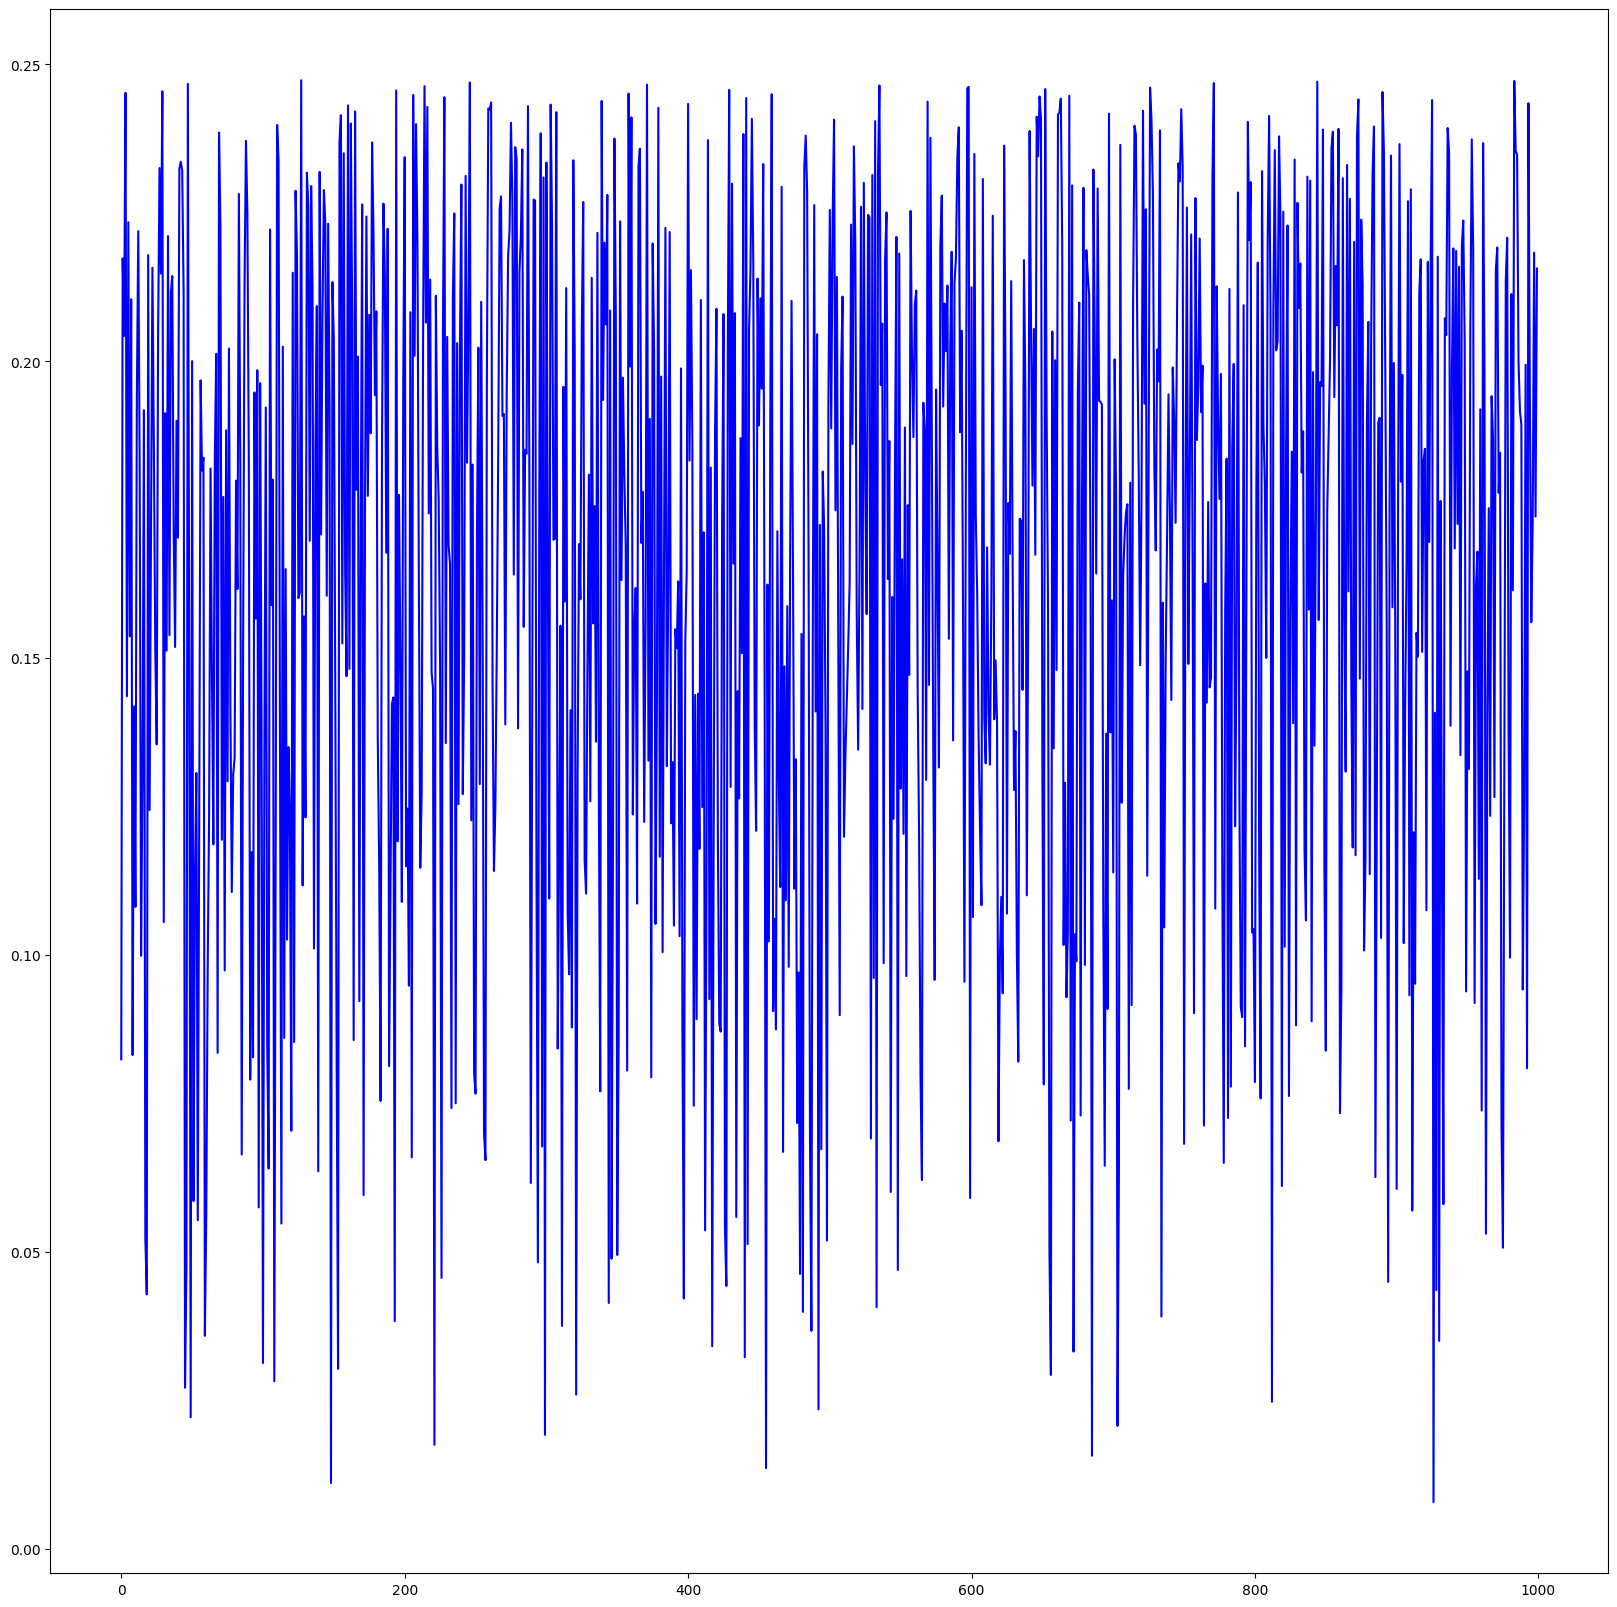

In [14]:
freqx = []
freqy = []
for x, y in zip(xvalid, yvalid):
     if x[1] == (500 -300)/ 400.0  and x[3] == (70 - 50) / 90.0 and x[0] == 1:
          freqx.append(x)
          freqy.append(y)

freqx = np.array(freqx)
freqy = np.array(freqy)

freqx = freqx[freqx[:, 2].argsort()]
freqy = freqy[freqx[:, 2].argsort()]
print(freqx.shape, freqy.shape)

ypred = model(torch.from_numpy(freqx))

plt.figure(figsize=(32, 48))
for c in range(1):
    plt.subplot(3, 2, c + 1)
    # plt.plot(range(100), ypred.detach().numpy()[100:200], color="red")
    plt.plot(range(1000), freqy[:, 0], color="blue")

plt.tight_layout()
plt.show()   

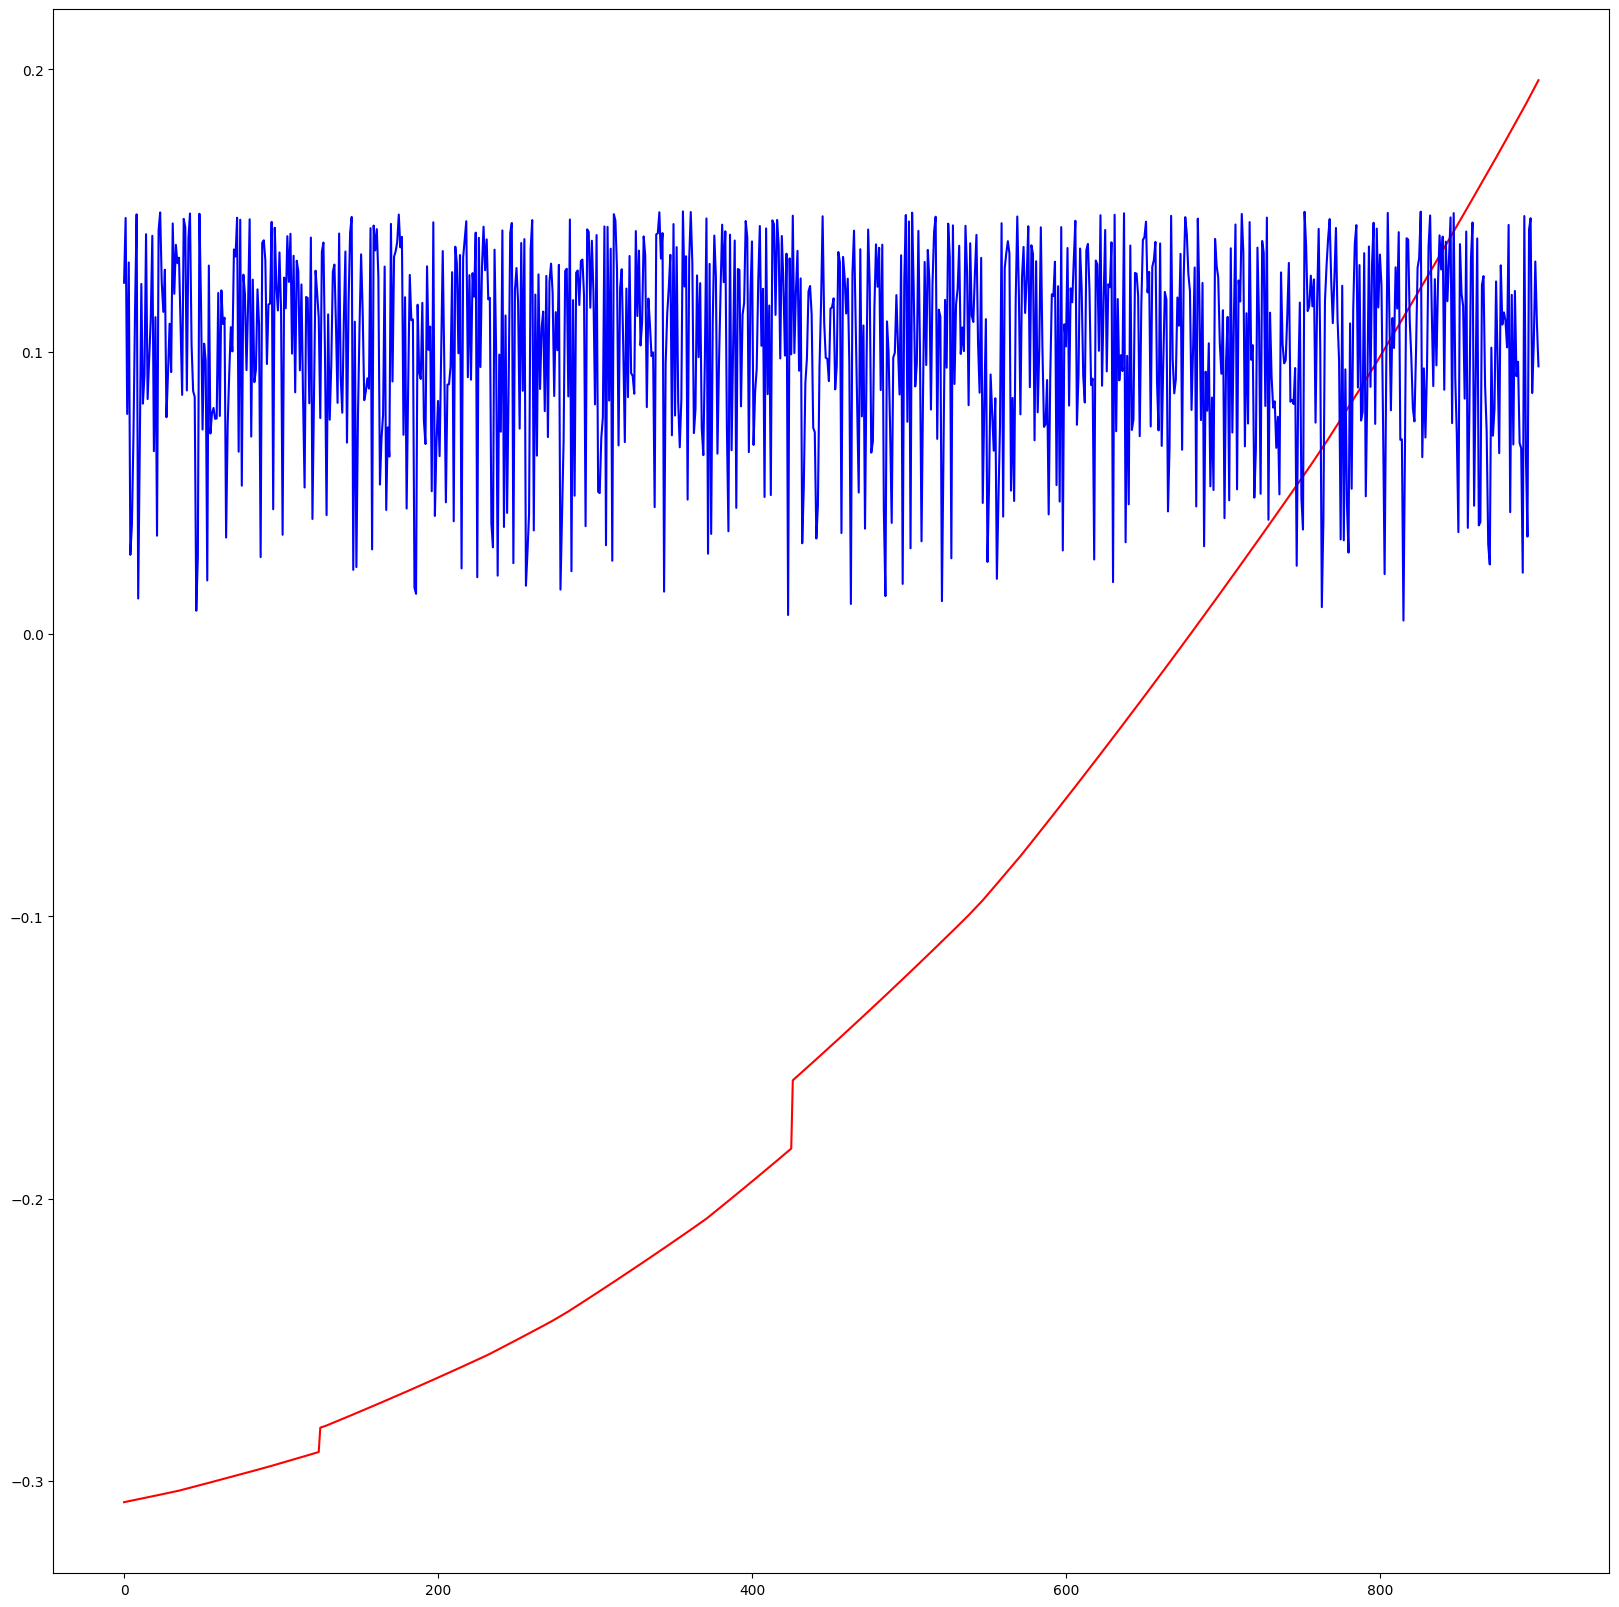

In [15]:
freqx = []
freqy = []
for x, y in zip(xtrain, ytrain):
     if x[1] == (600 -300)/ 400.0  and x[3] == (90 - 50) / 90.0 and x[0] == 1:
          freqx.append(x)
          freqy.append(y)

freqx = np.array(freqx)
freqy = np.array(freqy)

freqx = freqx[freqx[:,2].argsort()]
freqy = freqy[freqx[:, 2].argsort()]

ypred = model(torch.from_numpy(freqx))

plt.figure(figsize=(32, 48))
for c in range(1):
    plt.subplot(3, 2, c + 1)
    plt.plot(range(902), ypred.detach().numpy()[:, 0], color="red")
    plt.plot(range(902), freqy[:, 0], color="blue")

plt.tight_layout()
plt.show()   

6, 9, 2 == 91 r2 score


In [19]:
freqy.shape

(902, 2)